In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt


plt.style.use('seaborn-poster')

In [2]:
def read_alert_data(filename, include_region=True):
    rd = open(filename, "r")
    out = []
    while True:
        # Read next line
        line = rd.readline()
        # If line is blank, then you struck the EOF
        if len(line) > 0:
            if line[:2] == 'E:':
                out.append(line.strip())

        if not line :
            break;
    if include_region:
        df = pd.read_csv(StringIO('\n'.join(out)),
                 delim_whitespace=True, 
                 names=['E', 'id', 'evid', 'mag', 'evla', 'evlo',
                          'date', 'time', 'system', 'alert_time', 'est_mag',
                          'est_evla', 'est_evlo', 'est_date', 'est_time', 'region'])
    else:
        df = pd.read_csv(StringIO('\n'.join(out)),
                 delim_whitespace=True, 
                 names=['E', 'id', 'evid', 'mag', 'evla', 'evlo',
                          'date', 'time', 'system', 'alert_time', 'est_mag',
                          'est_evla', 'est_evlo', 'est_date', 'est_time'])
    
    return df

In [3]:
usgs_event_folder = '../data/ground_truth/'

In [31]:
myshake_network_detection = pd.read_pickle('../data/myshake_detection_results.pkl')
cnn_detection, model_file = pickle.load(open('../deep_learning_trainer/trained_model/ConvLSTM/1s_win_length_1imgStep/3_images/testing/detection_figures_0.5_steady_18_AGU_poster/detection.pkl', 'rb'))

# Get ShakeAlert messages
filename = '../data/shakeAlert/old_without_in_and_out/alerts2016.txt'
df_alert_2016 = read_alert_data(filename, False)
filename = '../data/shakeAlert/old_without_in_and_out/alerts2018.txt'
df_alert_2018 = read_alert_data(filename, False)

df_alert = pd.concat([df_alert_2016, df_alert_2018])

In [32]:
myshake_detection_count = 0
first_alert_time_compare_s = []
first_alert_time_compare_s_shakealert_cnn = []
shakealert_count = 0
myshake_detected_loc = []
shakealert_detected_loc = []
cnn_detected_loc = []

for key, detection in cnn_detection.items():
    
    earthquake = pickle.load(open(usgs_event_folder + key + '_ground_truth.pkl', 'rb'))
    evla = earthquake['latitude']
    evlo = earthquake['longitude']
    mag = earthquake['mag']
    
    myshake_detection = myshake_network_detection[key][0][0][0][0]
    shakealert_detection = df_alert[df_alert.evid == key]
    
    if len(myshake_detection) > 0:
        myshake_detection_count += 1
        myshake_detected_loc.append([evla, evlo, mag])
    if len(shakealert_detection) > 0:
        shakealert_count += 1 
        shakealert_detected_loc.append([evla, evlo, mag])
    if detection['detection']:
        cnn_detected_loc.append([evla, evlo, mag])
           
    if (len(myshake_detection) > 0) & (detection['detection']):
        cnn_detection_time = detection['alert_time']
        dmag, dkm, dsecs, myshake_detection_time, total_opt_fails, npwave, nswave, first_centroid_error = myshake_network_detection[key][0][1]
        alert_time_diff = myshake_detection_time - cnn_detection_time[0]
        first_alert_time_compare_s.append(alert_time_diff)
        
    if (len(shakealert_detection) > 0) & (detection['detection']):
        cnn_detection_time = detection['alert_time']
        shake_alert_detection = shakealert_detection.iloc[0]
        first_alert_time = shake_alert_detection.alert_time
        first_alert_time_compare_s_shakealert_cnn.append(first_alert_time - cnn_detection_time[0])
myshake_detected_loc = np.array(myshake_detected_loc)
shakealert_detected_loc = np.array(shakealert_detected_loc)
cnn_detected_loc = np.array(cnn_detected_loc)


In [33]:
min_v = min(first_alert_time_compare_s)
max_v = max(first_alert_time_compare_s)

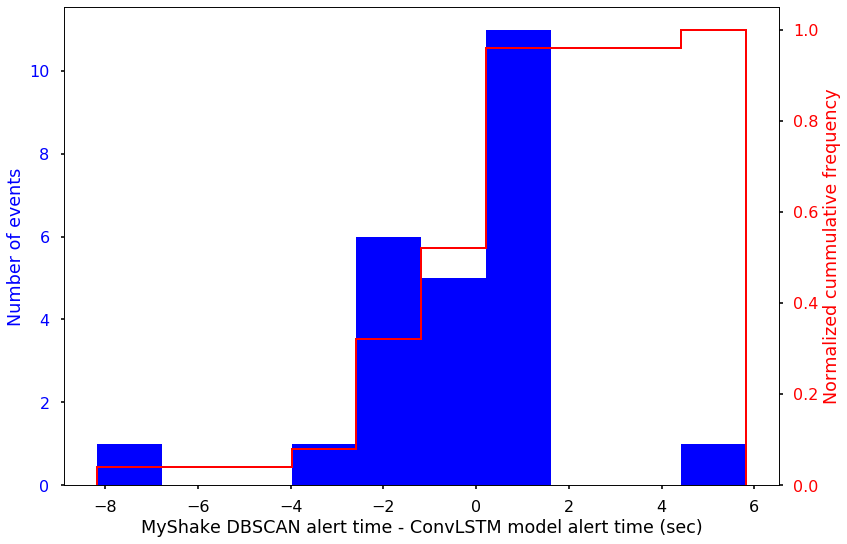

-0.39244001388549804 2.3013177273286636 0.11100006103515625


In [45]:
fig, ax1 = plt.subplots()
ax1.hist(first_alert_time_compare_s, color='b')
ax1.set_xlabel('MyShake DBSCAN alert time - ConvLSTM model alert time (sec)')
ax1.set_ylabel('Number of events', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()  # 
ax2.hist(first_alert_time_compare_s,
        cumulative=True, histtype='step', linewidth=2, color='r', density=True)
ax2.set_ylabel('Normalized cummulative frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.savefig("alert_time_difference_myshake_convlstm.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)
plt.show()

print(np.mean(first_alert_time_compare_s), np.std(first_alert_time_compare_s), np.median(first_alert_time_compare_s))



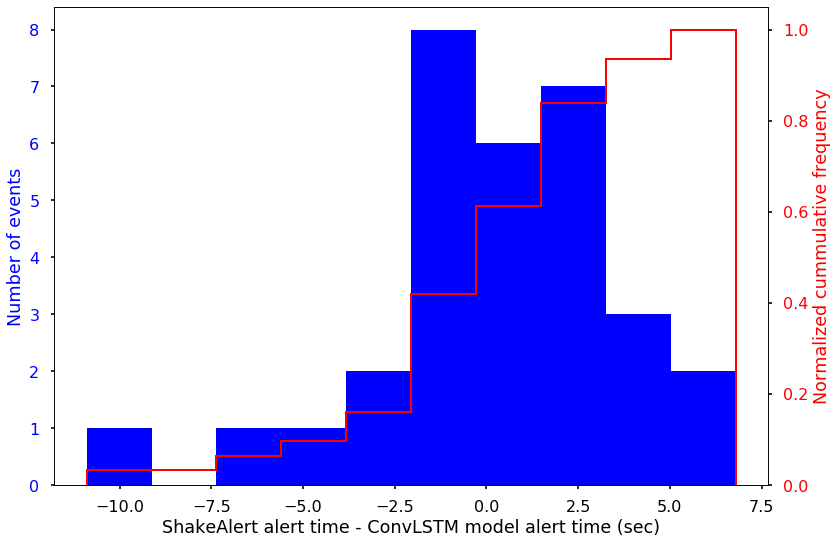

0.18387096774193537 3.477030321167536 0.5


In [46]:
fig, ax1 = plt.subplots()
ax1.hist(first_alert_time_compare_s_shakealert_cnn, 
        color='b')
ax1.set_xlabel('ShakeAlert alert time - ConvLSTM model alert time (sec)')
ax1.set_ylabel('Number of events', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()  # 
ax2.hist(first_alert_time_compare_s_shakealert_cnn,
        cumulative=True, histtype='step', linewidth=2, color='r', density=True)
ax2.set_ylabel('Normalized cummulative frequency', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.savefig("alert_time_difference_shakealert_convlstm.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)
plt.show()
print(np.mean(first_alert_time_compare_s_shakealert_cnn), np.std(first_alert_time_compare_s_shakealert_cnn), np.median(first_alert_time_compare_s_shakealert_cnn))



In [38]:
len(first_alert_time_compare_s_shakealert_cnn)

31

In [39]:
myshake_detection_count

36

In [40]:
shakealert_count

65

## Making a map

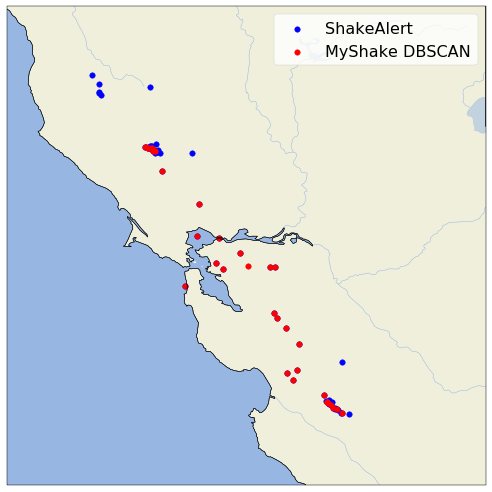

In [75]:
llat=36
ulat=40
llon=-124
ulon=-120
resolution = '10m'
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale(resolution))
ax.add_feature(cfeature.OCEAN.with_scale(resolution))
ax.add_feature(cfeature.COASTLINE.with_scale(resolution))
ax.add_feature(cfeature.BORDERS.with_scale(resolution), linestyle=':')
ax.add_feature(cfeature.LAKES.with_scale(resolution), alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale(resolution))
ax.add_feature(cfeature.STATES.with_scale(resolution))

cs = ax.scatter(shakealert_detected_loc[:, 1],
                shakealert_detected_loc[:, 0], marker='o',
                s=30, c='b', label='ShakeAlert')

cs = ax.scatter(myshake_detected_loc[:, 1],
                myshake_detected_loc[:, 0], marker='o',
                s=30, c='r', label='MyShake DBSCAN')

plt.savefig("myshake_shakealert_detection.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)

plt.legend()
plt.show()

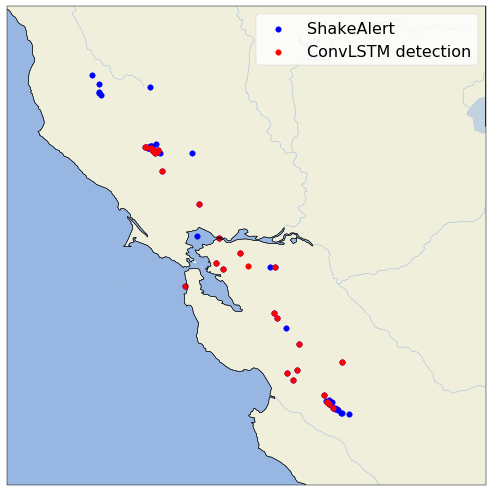

In [41]:
llat=36
ulat=40
llon=-124
ulon=-120
resolution = '10m'
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale(resolution))
ax.add_feature(cfeature.OCEAN.with_scale(resolution))
ax.add_feature(cfeature.COASTLINE.with_scale(resolution))
ax.add_feature(cfeature.BORDERS.with_scale(resolution), linestyle=':')
ax.add_feature(cfeature.LAKES.with_scale(resolution), alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale(resolution))
ax.add_feature(cfeature.STATES.with_scale(resolution))

cs = ax.scatter(shakealert_detected_loc[:, 1],
                shakealert_detected_loc[:, 0], marker='o',
                s=30, c='b', label='ShakeAlert')

cs = ax.scatter(cnn_detected_loc[:, 1],
                cnn_detected_loc[:, 0], marker='o',
                s=30, c='r', label='ConvLSTM detection')

plt.savefig("shakealert_convlstm_detection.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)

plt.legend()
plt.show()

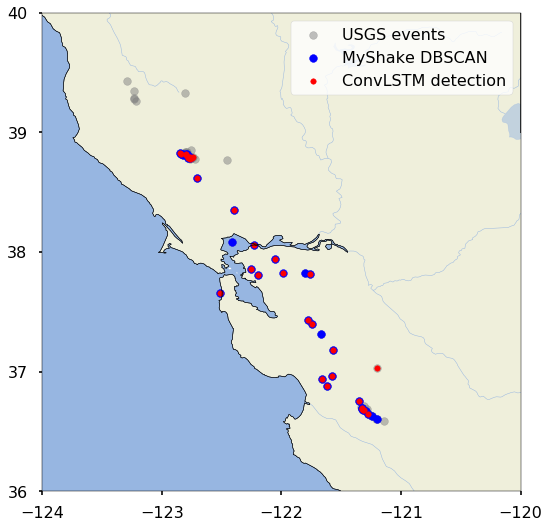

In [42]:
llat=36
ulat=40
llon=-124
ulon=-120
resolution = '10m'
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND.with_scale(resolution))
ax.add_feature(cfeature.OCEAN.with_scale(resolution))
ax.add_feature(cfeature.COASTLINE.with_scale(resolution))
ax.add_feature(cfeature.BORDERS.with_scale(resolution), linestyle=':')
ax.add_feature(cfeature.LAKES.with_scale(resolution), alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale(resolution))
ax.add_feature(cfeature.STATES.with_scale(resolution))

ax.set_xticks(np.arange(llon, ulon+0.1, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(llat, ulat+0.1, 1), crs=ccrs.PlateCarree())
  

cs = ax.scatter(shakealert_detected_loc[:, 1],
                shakealert_detected_loc[:, 0], marker='o',
                s=60, c='grey', label='USGS events', alpha=0.5)
    
cs = ax.scatter(myshake_detected_loc[:, 1],
                myshake_detected_loc[:, 0], marker='o',
                s=60, c='b', label='MyShake DBSCAN')

cs = ax.scatter(cnn_detected_loc[:, 1],
                cnn_detected_loc[:, 0], marker='o',
                s=30, c='r', label='ConvLSTM detection')

plt.legend()
plt.savefig("myshake_convlstm_detection.jpg", bbox_inches = 'tight', dpi=300,
    pad_inches = 0.1)


plt.show()